# 🔤 OCR Module — PaddleOCR v3.x (PP-OCRv5)
**CXC 2026 Hackathon — Blind Assistance App**

### What this does
This reads text from the camera feed — signs, store names, menus, labels, etc.  
It runs in the background every ~0.5 seconds while YOLO handles object detection at 30 FPS.

### How it fits in the pipeline
```
Camera Frame → [YOLO: objects] + [PaddleOCR: text] → Combined context → Gemini → TTS → User hears response
```

### What changed from old PaddleOCR
We're using **PaddleOCR 3.x** (PP-OCRv5) — the latest version.  
- 13% more accurate than v4 at reading text
- New `.predict()` API (old `.ocr()` still works but is deprecated)
- Results come as structured objects with built-in `.print()`, `.save_to_img()`, etc.
- Handles English + multilingual out of the box

---
## 1. Installation

PaddleOCR 3.x needs **two** packages:
1. `paddlepaddle` — the deep learning engine (like PyTorch but from Baidu)
2. `paddleocr` — the OCR library that runs on top of it
3. `opencv-python` — for camera access and display windows

Think of it like: `paddlepaddle` = engine, `paddleocr` = the car, `opencv` = the camera

In [32]:
# Step 1: Install PaddlePaddle (the engine)
# CPU version — works on any laptop
!pip install paddlepaddle

# If you have an NVIDIA GPU and want faster processing, use this instead:
# !pip install paddlepaddle-gpuqh

# Fix opencv for display windows
!pip uninstall opencv-python-headless -y
!pip uninstall opencv-python -y
!pip install opencv-python

Found existing installation: opencv-python-headless 4.13.0.92
Uninstalling opencv-python-headless-4.13.0.92:
  Successfully uninstalled opencv-python-headless-4.13.0.92
Found existing installation: opencv-python 4.13.0.92
Uninstalling opencv-python-4.13.0.92:
  Successfully uninstalled opencv-python-4.13.0.92
  Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.13.0.92-cp37-abi3-win_amd64.whl (40.2 MB)


In [33]:
# Step 2: Install PaddleOCR (the OCR library)
!pip install paddleocr

# Step 3: Other stuff we need
!pip install opencv-python-headless numpy

  Using cached opencv_python_headless-4.13.0.92-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.13.0.92-cp37-abi3-win_amd64.whl (40.1 MB)


---
## 2. Imports & Setup

Loading all the libraries we need.

In [34]:
import os
os.environ["FLAGS_use_mkldnn"] = "0"

import cv2
import numpy as np
import time
import threading
from typing import Optional
from dataclasses import dataclass
from paddleocr import PaddleOCR

print("All imports loaded")

All imports loaded


---
## 3. Data Structures

These are just containers to organize the OCR results in a clean way.  
Other modules (Gemini, TTS) will use these to understand what text was found and where.

**Why we need this:**  
PaddleOCR gives us raw arrays of numbers. These classes turn that into something
readable like: `"REXALL PHARMACY" found on the LEFT side of the frame with 98% confidence`

In [35]:
@dataclass
class TextDetection:
    """
    Represents ONE piece of text found in the camera frame.
    
    Example:
        text = "REXALL PHARMACY"
        confidence = 0.98  (98% sure it read correctly)
        position = "left"  (it's on the left side of what the camera sees)
    """
    text: str           # the actual text that was read
    confidence: float   # how sure the model is (0.0 to 1.0)
    bbox: np.ndarray    # bounding box coordinates (4 corners)
    center_x: int = 0   # center x position in the frame
    center_y: int = 0   # center y position in the frame
    position: str = ""  # "left", "center", or "right"


@dataclass
class OCRResult:
    """
    All the text found in a single camera frame.
    Contains a list of TextDetection objects + some metadata.
    """
    detections: list          # list of TextDetection objects
    timestamp: float = 0.0    # when this scan happened
    scan_time_ms: float = 0.0 # how long the scan took in milliseconds
    frame_width: int = 0
    frame_height: int = 0
    
    def get_all_text(self) -> str:
        """
        Returns all detected text as one string.
        Used when sending context to Gemini.
        
        Example output: "REXALL PHARMACY | OPEN 9AM-9PM | EXIT"
        """
        return " | ".join([d.text for d in self.detections])
    
    def get_text_with_positions(self) -> str:
        """
        Returns text WITH spatial info (where it is in the frame).
        This helps Gemini give directional instructions.
        
        Example output:
            [LEFT] 'REXALL PHARMACY' (98%)
            [CENTER] 'OPEN 9AM-9PM' (95%)
            [RIGHT] 'EXIT' (92%)
        """
        lines = []
        for d in self.detections:
            lines.append(f"[{d.position.upper()}] '{d.text}' ({d.confidence:.0%})")
        return "\n".join(lines)


print("Data structures defined")

Data structures defined


---
## 4. OCR Engine

This is the main class that wraps PaddleOCR.  

**What it does:**
1. Takes a camera frame (image)
2. Runs PaddleOCR's PP-OCRv5 model on it
3. Filters out junk/low-confidence results
4. Figures out WHERE each text is (left/center/right) — important for telling a blind person "the sign is to your LEFT"
5. Returns a clean `OCRResult` object

**Speed settings:**
- We disable doc orientation + unwarping (not needed for real-time camera)
- We use the `mobile` models (faster) instead of `server` models (more accurate but slower)
- You can swap to `server` models if you have a good GPU

In [36]:
class OCREngine:
    """
    Simple OCR engine — call scan_frame() when you need to read text.
    Not running in background. Just call it when needed.
    
    Usage:
        engine = OCREngine()
        result = engine.scan_frame(frame)
        print(result.get_all_text())  # "REXALL PHARMACY | OPEN 9AM-9PM"
    """
    
    def __init__(self, confidence_threshold: float = 0.6, use_gpu: bool = False,
                 scale_factor: float = 0.5):
        print("Loading PaddleOCR model (first time downloads ~200MB)...")
        start = time.time()
        
        self.ocr = PaddleOCR(
            lang='en',
            use_doc_orientation_classify=False,
            use_doc_unwarping=False,
            use_textline_orientation=False,
            text_detection_model_name='PP-OCRv5_mobile_det',
            text_recognition_model_name='PP-OCRv5_mobile_rec',
            enable_mkldnn=False,
        )
        
        self.confidence_threshold = confidence_threshold
        self.scale_factor = scale_factor
        
        elapsed = time.time() - start
        print(f"PaddleOCR loaded in {elapsed:.1f}s")
    
    
    def _get_position(self, center_x: int, frame_width: int) -> str:
        third = frame_width / 3
        if center_x < third:
            return "left"
        elif center_x < 2 * third:
            return "center"
        else:
            return "right"
    
    
    def scan_frame(self, frame: np.ndarray) -> OCRResult:
        """
        Call this when user wants to read text.
        Pass in the current camera frame, get back all detected text.
        """
        start = time.time()
        h, w = frame.shape[:2]
        
        if self.scale_factor < 1.0:
            small_frame = cv2.resize(frame, None,
                                      fx=self.scale_factor,
                                      fy=self.scale_factor)
        else:
            small_frame = frame
        
        results = self.ocr.predict(input=small_frame)
        
        detections = []
        
        for res in results:
            if isinstance(res, dict):
                res_dict = res.get('res', res)
            else:
                try:
                    res_dict = res['res']
                except (KeyError, TypeError):
                    try:
                        res_dict = res.json if hasattr(res, 'json') else {}
                    except:
                        continue
            
            rec_texts = res_dict.get('rec_texts', [])
            rec_scores = res_dict.get('rec_scores', [])
            rec_polys = res_dict.get('rec_polys', [])
            
            for i in range(len(rec_texts)):
                text = str(rec_texts[i]).strip()
                score = float(rec_scores[i]) if i < len(rec_scores) else 0.0
                
                if score < self.confidence_threshold:
                    continue
                if len(text) < 2:
                    continue
                
                if i < len(rec_polys):
                    bbox = np.array(rec_polys[i], dtype=np.float32)
                    if self.scale_factor < 1.0:
                        bbox = bbox / self.scale_factor
                    bbox = bbox.astype(np.int32)
                else:
                    bbox = np.array([])
                
                if bbox.size > 0:
                    cx = int(np.mean(bbox[:, 0]))
                    cy = int(np.mean(bbox[:, 1]))
                else:
                    cx, cy = 0, 0
                
                det = TextDetection(
                    text=text,
                    confidence=score,
                    bbox=bbox,
                    center_x=cx,
                    center_y=cy,
                    position=self._get_position(cx, w)
                )
                detections.append(det)
        
        detections.sort(key=lambda d: d.confidence, reverse=True)
        
        return OCRResult(
            detections=detections,
            timestamp=time.time(),
            scan_time_ms=(time.time() - start) * 1000,
            frame_width=w,
            frame_height=h
        )


print("OCREngine class defined")

OCREngine class defined


---
## 5. Start the Engine

First run downloads the PP-OCRv5 model (~200MB). After that it loads from cache.

In [37]:
engine = OCREngine(
    confidence_threshold=0.6,  # tune: 0.5 = more text, 0.7 = less noise
    use_gpu=False              # set True if NVIDIA GPU + CUDA installed
)

C:\Users\s2jal\AppData\Local\Temp\ipykernel_35672\3134927343.py:17: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  self.ocr = PaddleOCR(
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\s2jal\.paddlex\official_models\PP-OCRv5_mobile_det`.


Loading PaddleOCR model (first time downloads ~200MB)...


Creating model: ('PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\s2jal\.paddlex\official_models\PP-OCRv5_mobile_rec`.


PaddleOCR loaded in 1.3s


---
## 6. Test on a Single Frame

Quick check — grab one webcam frame, run OCR, see what it reads.  
Point camera at something with text (book, phone, sign, etc).

In [38]:
# Grab one frame from webcam
cap = cv2.VideoCapture(0)
ret, test_frame = cap.read()
cap.release()

if ret:
    result = engine.scan_frame(test_frame)
    
    print(f"Scan took: {result.scan_time_ms:.0f}ms")
    print(f"Found {len(result.detections)} text regions\n")
    print("=== Detected Text ===")
    print(result.get_text_with_positions())
    print(f"\n=== Combined for Gemini ===")
    print(result.get_all_text())
else:
    print("Couldn't access webcam. Try the image file test below.")

Scan took: 273ms
Found 1 text regions

=== Detected Text ===
[CENTER] 'REXALL' (99%)

=== Combined for Gemini ===
REXALL


In [39]:
# ALTERNATIVE: test with an image file
# Uncomment and change the path:

# test_frame = cv2.imread("path/to/your/image.jpg")
# result = engine.scan_frame(test_frame)
# print(result.get_text_with_positions())

---
## 7. Visualize Detections

Draws green boxes around detected text. Good for debugging.

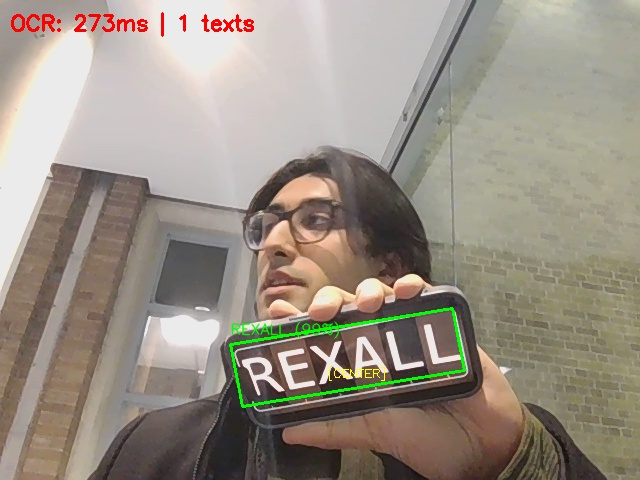

Green boxes = detected text, yellow = position (LEFT/CENTER/RIGHT)


In [40]:
def draw_ocr_results(frame: np.ndarray, result: OCRResult) -> np.ndarray:
    """Draw bounding boxes + labels on frame for visualization."""
    annotated = frame.copy()
    
    for det in result.detections:
        if det.bbox.size == 0:
            continue
        
        # Green bounding box
        pts = det.bbox.astype(np.int32)
        cv2.polylines(annotated, [pts], True, (0, 255, 0), 2)
        
        # Text label above box
        label = f"{det.text} ({det.confidence:.0%})"
        x, y = int(pts[0][0]), int(pts[0][1]) - 10
        cv2.putText(annotated, label, (x, max(y, 15)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        
        # Position tag (LEFT/CENTER/RIGHT)
        cv2.putText(annotated, f"[{det.position.upper()}]",
                    (det.center_x - 20, det.center_y + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
    
    # Stats top-left
    cv2.putText(annotated, f"OCR: {result.scan_time_ms:.0f}ms | {len(result.detections)} texts",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    return annotated


# Show annotated frame in notebook
if ret:
    annotated = draw_ocr_results(test_frame, result)
    from IPython.display import display, Image as IPImage
    _, buf = cv2.imencode('.jpg', annotated)
    display(IPImage(data=buf.tobytes()))
    print("Green boxes = detected text, yellow = position (LEFT/CENTER/RIGHT)")

---
## 8. Live Webcam OCR Loop

Opens a window showing camera feed with text boxes drawn on it.  
Press **q** to quit. This is a standalone demo — for the real app use Section 9.

In [41]:
def run_ocr_live(engine: OCREngine, scan_interval: float = 0.5, num_scans: int = 10):
    """Live OCR on webcam — displays frames inside the notebook."""
    from IPython.display import display, Image as IPImage, clear_output
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Can't open webcam")
        return
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    print(f"🎥 Running {num_scans} OCR scans (every {scan_interval}s)...\n")
    
    try:
        for i in range(num_scans):
            ret, frame = cap.read()
            if not ret:
                print("Lost webcam connection")
                break
            
            result = engine.scan_frame(frame)
            annotated = draw_ocr_results(frame, result)
            
            # Display frame in notebook
            clear_output(wait=True)
            _, buf = cv2.imencode('.jpg', annotated)
            display(IPImage(data=buf.tobytes()))
            
            if result.detections:
                print(f"Scan {i+1}/{num_scans} ({result.scan_time_ms:.0f}ms): {result.get_all_text()}")
            else:
                print(f"Scan {i+1}/{num_scans} ({result.scan_time_ms:.0f}ms): no text")
            
            time.sleep(scan_interval)
    
    finally:
        cap.release()
        print(f"\nDone!")

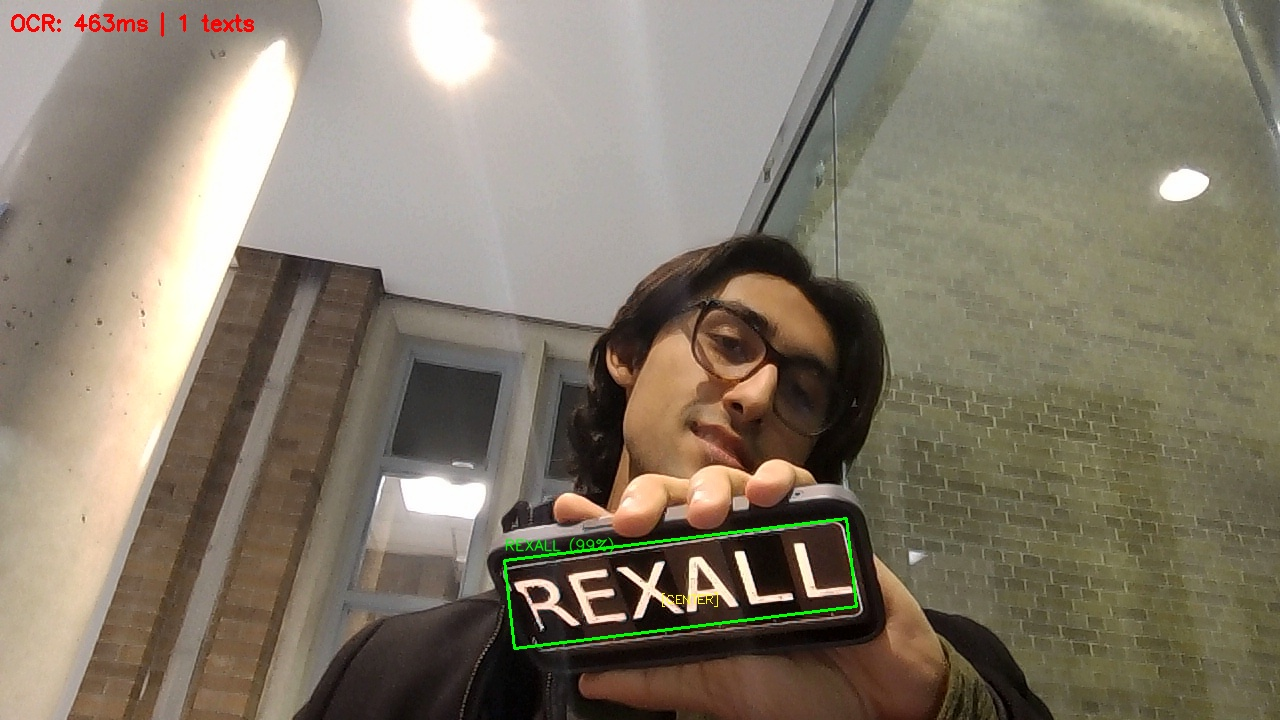

Scan 10/10 (463ms): REXALL

Done!


In [42]:
# Run it! Point webcam at text.
run_ocr_live(engine, scan_interval=1.0, num_scans=10)

---
## 9. Gemini Context Builder

Formats OCR + YOLO results into a string for Gemini.  
This gets appended to the user's voice query so Gemini knows what's visible.

**Example flow:**
1. User says: *"Where is the pharmacy?"*  
2. We build context: `VISIBLE TEXT: [left] 'REXALL PHARMACY' (98%)`
3. Full prompt to Gemini: *"Where is the pharmacy? Environment: VISIBLE TEXT: [left] 'REXALL PHARMACY' (98%)"*
4. Gemini responds: *"Rexall Pharmacy is to your left."*

In [ ]:
def build_gemini_context(ocr_result: Optional[OCRResult],
                         yolo_detections: list = None) -> str:
    """
    Build environment description for Gemini.
    
    Args:
        ocr_result: from engine.scan_frame(frame)
        yolo_detections: from YOLO module, format: [{"label": "person", "position": "left"}, ...]
    
    Returns:
        String like:
            VISIBLE TEXT: [left] 'REXALL' (98%) | [center] 'OPEN' (95%)
            OBJECTS: person (left), bench (center), door (right)
    """
    parts = []
    
    if ocr_result and ocr_result.detections:
        text_parts = []
        for d in ocr_result.detections[:10]:
            text_parts.append(f"[{d.position}] '{d.text}' ({d.confidence:.0%})")
        parts.append("VISIBLE TEXT: " + " | ".join(text_parts))
    else:
        parts.append("VISIBLE TEXT: None detected")
    
    if yolo_detections:
        obj_parts = [f"{obj['label']} ({obj['position']})" for obj in yolo_detections[:10]]
        parts.append("OBJECTS: " + ", ".join(obj_parts))
    
    return "\n".join(parts)


# Demo — uses 'result' from Section 6
if result and result.detections:
    print("=== Gemini context (OCR only) ===")
    print(build_gemini_context(result))
    
    # With fake YOLO data
    fake_yolo = [{"label": "person", "position": "center"}, {"label": "door", "position": "right"}]
    print("\n=== Gemini context (OCR + YOLO) ===")
    print(build_gemini_context(result, fake_yolo))
else:
    print("Run Section 6 first to get OCR results")

AttributeError: 'OCREngine' object has no attribute 'get_latest'

---
## 📋 Cheat Sheet for Teammates

### Install (one time)
```bash
pip install paddlepaddle paddleocr opencv-python-headless numpy
```

### Plug into main app
```python
from ocr import OCRScanner, build_gemini_context

scanner = OCRScanner(scan_interval=0.5)
scanner.start()

# In main camera loop:
scanner.update_frame(frame)
ocr_result = scanner.get_latest()

# When user asks a question:
context = build_gemini_context(ocr_result, yolo_detections)
prompt = f"{user_voice_query}\n\nEnvironment:\n{context}"
# Send to Gemini...

scanner.stop()
```

### Tuning
| Setting | Low | High |
|---------|-----|------|
| `confidence_threshold` | 0.4 = more text, more junk | 0.8 = only clear text |
| `scan_interval` | 0.2 = scans often, more CPU | 1.0 = scans less, saves CPU |

### Want better accuracy? (needs GPU)
Change model names in `OCREngine.__init__()`:
```python
text_detection_model_name='PP-OCRv5_server_det'
text_recognition_model_name='PP-OCRv5_server_rec'
```